In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



In [2]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(12,activation='softmax')(x) 

In [3]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [4]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [5]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [6]:
! pip install kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d harshul23/garbage

mkdir: cannot create directory ‘/root/.kaggle’: File exists
garbage.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip garbage.zip

Archive:  garbage.zip
replace dataset/Dataset/Test/Cardboard/cardboard10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/Dataset/Test/Cardboard/cardboard10.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard100.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard101.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard102.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard103.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard104.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard105.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard106.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard107.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard108.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard109.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard11.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard110.jpg  
  inflating: dataset/Dataset/Test/Cardboard/cardboard111.jpg  
  

In [8]:
main_dir = "dataset/Dataset"
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir(main_dir)))
random.shuffle(imagePaths)
print(imagePaths)


['Train', 'Test']


In [9]:
!rm /content/dataset/Dataset/Train/cardboard/.ipynb_checkpoints
!rm /content/dataset/Dataset/Train/cardboard/Thumbs.db

rm: cannot remove '/content/dataset/Dataset/Train/cardboard/.ipynb_checkpoints': No such file or directory


In [10]:
for direc in imagePaths:
    path=sorted(list(os.listdir("/content/dataset/Dataset/"+direc)))
    for img in path:
        path2=sorted(list(os.listdir("/content/dataset/Dataset/"+direc+'/'+img)))
        for i in path2:
            image = cv2.imread(("/content/dataset/Dataset/"+direc+'/'+img+'/'+i))
            image = cv2.resize(image, (128,128))
            image = img_to_array(image)
            data.append(image)
            l = label = img
            labels.append(l)

In [11]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 0 0 0 1 0 0 0 0 0]


In [12]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(1516, 128, 128, 3) (1011, 128, 128, 3)


In [13]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=30,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.93919, saving model to model.h5
11/11 - 45s - loss: 2.8447 - accuracy: 0.2918 - val_loss: 1.9392 - val_accuracy: 0.4156 - lr: 0.0010 - 45s/epoch - 4s/step
Epoch 2/30

Epoch 00002: val_loss improved from 1.93919 to 1.48715, saving model to model.h5
11/11 - 11s - loss: 1.7811 - accuracy: 0.5072 - val_loss: 1.4872 - val_accuracy: 0.5053 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 3/30

Epoch 00003: val_loss improved from 1.48715 to 1.16785, saving model to model.h5
11/11 - 11s - loss: 1.4221 - accuracy: 0.5591 - val_loss: 1.1678 - val_accuracy: 0.6102 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 4/30

Epoch 00004: val_loss improved from 1.16785 to 1.04383, saving model to model.h5
11/11 - 11s - loss: 1.2771 - accuracy: 0.5893 - val_loss: 1.0438 - val_accuracy: 0.6590 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 5/30

Epoch 00005: val_loss improved from 1.04383 to 0.92233, saving model to model.h5
11/11 - 11s - loss: 1.1435 - accuracy: 0.6311 -

Text(0.5, 0, 'epoch')

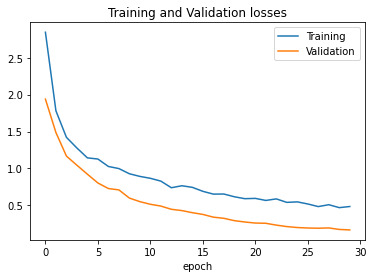

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

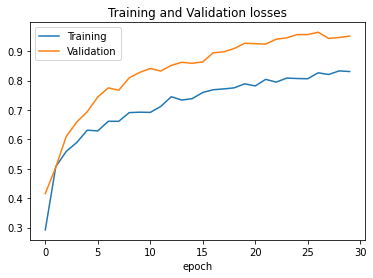

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')